# Numba implementation of greedy search

Allow just-in-time compilation with numba.

In [38]:
RUN_BENCHMARKS = True

## Test data

As test data we generate simple binary random matrices $R \in \{0, 1\}^{m \times n}$ with a fixed proportion of 1-entries ($\alpha=0.5$) for a range of $n$ and $m$ values.

In [20]:
import numpy as np
import pandas as pd

RNG = np.random.default_rng(seed=0)

In [21]:
def rand_array(size, alpha=0.2):
    n, k = size
    d = np.arange(n*k)
    RNG.shuffle(d)
    d = (d < alpha*len(d)).astype(int)
    return d.reshape(n, k)

In [22]:
d_tiny = rand_array((10, 5), alpha=0.5)
d_tiny

array([[1, 1, 0, 1, 1],
       [1, 0, 1, 1, 0],
       [1, 1, 0, 1, 1],
       [0, 0, 0, 1, 1],
       [0, 1, 0, 1, 0],
       [0, 0, 1, 1, 0],
       [0, 1, 0, 0, 0],
       [1, 0, 0, 1, 1],
       [1, 0, 0, 1, 1],
       [0, 0, 0, 1, 0]])

In [23]:
ns = np.arange(5, 51, 5)
ms = np.arange(50, 501, 50)

alpha = 0.5

d = {}
for m in ms:
    for n in ns:
        X = rand_array((m, n), alpha=alpha)
        true_weights = RNG.random(n) * 10
        y = X @ true_weights + RNG.random(m)
        y = np.sign(y - y.mean())
        dfX = pd.DataFrame(data=X, index=None, columns=[f'x{i}' for i in range(X.shape[1])])
        dfy = pd.Series(data=y)
        d[(m, n)] = (dfX, dfy)

## Existing implementation

In [24]:
from realkd.rules import RuleBoostingEstimator, XGBRuleEstimator, logistic_loss

re = RuleBoostingEstimator(base_learner=XGBRuleEstimator(loss=logistic_loss, search='greedy'))

def re_fit(data):
  re.fit(data[0], data[1])

In [25]:
try:
    t_bm = t_bm if t_bm is not None else {}
except:
    t_bm = {}

if RUN_BENCHMARKS:
    t_bm = {}

    for i in ms:
        t_bm[(i, ns[0])] = %timeit -o re_fit(d[(i, ns[0])])

    for i in ns:
        t_bm[(ms[0], i)] = %timeit -o re_fit(d[(ms[0], i)])

In [26]:
import matplotlib.pyplot as plt

t_bm_mean = [t_bm[(i, ns[0])].average for i in ms]
t_bm_std = [t_bm[(i, ns[0])].stdev for i in ms]
plt.subplots(1, 2, figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(ms, t_bm_mean, marker='o')
plt.xlim(ms[0], ms[-1])
plt.xlabel('$m$')

plt.subplot(1, 2, 2)
t_bm_mean = [t_bm[(ms[0], j)].average for j in ns]
t_bm_std = [t_bm[(ms[0], j)].stdev for j in ns]
plt.plot(ns, t_bm_mean, marker='o')
plt.xlim(ns[0], ns[-1])
plt.xlabel('$n$')

plt.show()

KeyError: (50, 5)

# Numba just-in-time compilation - Building it up from 0

In [28]:
from numba import njit

## Intersection

In [31]:
def baseNumpyIntersection(arr1, arr2):
    return np.intersect1d(arr1, arr2)


@njit()
def numbaNumpyIntersection(arr1, arr2):
    return np.intersect1d(arr1, arr2)

list1 = np.arange(100)
list2 = np.arange(50, 100)

# Run the function first before testing to compile it
numbaNumpyIntersection(list1, list2)
# print(numbaNumpyIntersection.inspect_types())
if RUN_BENCHMARKS:
    %timeit -o baseNumpyIntersection(list1, list2)
    %timeit -o numbaNumpyIntersection(list1, list2)

## Objective Function

In [42]:
from numpy import array, argsort, zeros_like
from math import inf

def build_numba_obj_function(X, y):
    loss = logistic_loss # TODO: Generalize
    reg = 1.0 # TODO: Generalize
    predictions = zeros_like(y) # TODO: Generalize
    g = array(loss.g(y, predictions))
    h = array(loss.h(y, predictions))
    r = g / h
    order = argsort(r)[::-1]
    g = g[order]
    h = h[order]
    n = y.shape[0]

    @njit
    def objective_function(ext):
        if len(ext) == 0:
            return -inf
        g_q = g[ext]
        h_q = h[ext]
        return g_q.sum() ** 2 / (2 * n * (reg + h_q.sum()))

    return objective_function

def get_ghreg(X, y):
    loss = logistic_loss # TODO: Generalize
    reg = 1.0 # TODO: Generalize
    predictions = zeros_like(y) # TODO: Generalize
    g = array(loss.g(y, predictions))
    h = array(loss.h(y, predictions))
    r = g / h
    order = argsort(r)[::-1]
    g = g[order]
    h = h[order]
    n = y.shape[0]

    return (g, h, reg)

@njit
def objective_function(g, h, reg, ext):
    if len(ext) == 0:
        return -inf
    g_q = g[ext]
    h_q = h[ext]
    return g_q.sum() ** 2 / (2 * n * (reg + h_q.sum()))

test_data_1 = d[(ms[0],ns[0])]
test_data_2 = d[(ms[0],ns[0])]
test_extent = np.arange(5, 20)

g1, h1, reg1 = get_ghreg(test_data_1[0], test_data_1[1])
g2, h2, reg2 = get_ghreg(test_data_2[0], test_data_2[1])

obj_fn_1 = build_numba_obj_function(test_data_1[0], test_data_1[1])
obj_fn_2 = build_numba_obj_function(test_data_2[0], test_data_2[1])
# obj_fn_3 = objective_function
# obj_fn_4 = objective_function

# Run the function first before testing to compile it
# print(obj_fn_1(test_extent))
# print(objective_function(g1, h1, reg1,test_extent))
# obj_fn.inspect_types()

if RUN_BENCHMARKS:
    %timeit -o -n 1 obj_fn_1(test_extent)
    %timeit -o -n 1 obj_fn_2(test_extent)
    %timeit -o -n 1 objective_function(g1, h1, reg1, test_extent)
    %timeit -o -n 1 objective_function(g1, h1, reg1, test_extent)

The slowest run took 391715.07 times longer than the fastest. This could mean that an intermediate result is being cached.
28 ms ± 68.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
The slowest run took 291773.43 times longer than the fastest. This could mean that an intermediate result is being cached.
20.8 ms ± 51 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
The slowest run took 200779.75 times longer than the fastest. This could mean that an intermediate result is being cached.
20.1 ms ± 49.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
The slowest run took 6.14 times longer than the fastest. This could mean that an intermediate result is being cached.
1.33 µs ± 1.22 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


## Numba just-in-time compilation - putting it all together

In [71]:
from realkd.rules import RuleBoostingEstimator, XGBRuleEstimator, logistic_loss
from realkd.search import search_methods
from numba import njit
import pandas as pd
import sortednp as snp
import doctest

from collections import defaultdict, deque
from sortedcontainers import SortedSet
from math import inf
from heapq import heappop, heappush
from numpy import array
from bitarray import bitarray
import collections.abc

from math import inf
from numpy import arange, argsort, array, cumsum, exp, full_like, log2, stack, zeros, zeros_like
from pandas import qcut, Series
from sklearn.base import BaseEstimator, clone

from realkd.search import Conjunction, Context, KeyValueProposition, Constraint
from bitarray.util import subset

from realkd.logic import Conjunction, Constraint, KeyValueProposition, TabulatedProposition

re = RuleBoostingEstimator(base_learner=XGBRuleEstimator(loss=logistic_loss, search='numba_greedy'))

def get_ghreg(X, y):
    loss = logistic_loss # TODO: Generalize
    reg = 1.0 # TODO: Generalize
    predictions = zeros_like(y) # TODO: Generalize
    g = array(loss.g(y, predictions))
    h = array(loss.h(y, predictions))
    r = g / h
    order = argsort(r)[::-1]
    g = g[order]
    h = h[order]
    n = y.shape[0]

    return (g, h, reg)

@njit
def objective_function(g, h, reg, ext):
    if len(ext) == 0:
        return -inf
    g_q = g[ext]
    h_q = h[ext]
    return g_q.sum() ** 2 / (2 * n * (reg + h_q.sum()))

@njit
def my_intersect(arr1, arr2):
    return np.array(set(arr1).intersection(arr2))

# https://stackoverflow.com/questions/59959207/intersection-of-two-lists-in-numba
@njit()
def JitListComp(l1, l2):
    l3 = np.array([i for i in l1 for j in l2 if i == j])
    return np.unique(l3)

@njit()
def numpy(l1, l2):
    return np.intersect1d(l1, l2)

# TODO: Clean up code inc. removing argument passing
@njit
def find_best_new_index(current_intent, current_extent, extents, initial_value, f, n, g, h, reg):
    best_i, best_ext = None, current_extent
    value = initial_value
    for i in range(n):
        if i in current_intent:
            continue
        new_extent = numpy(current_extent, extents[i])
        new_value = f(g, h, reg, new_extent)
        if new_value > value:
            value = new_value
            best_ext = new_extent
            best_i = i
    return (best_i, best_ext, value)

@njit
def numba_run(extent, n, extents, f, g, h, reg):
    """
    Runs the configured search.

    :return: :class:`~realkd.logic.Conjunction` that (approximately) maximizes objective
    """
    # print(g, h, reg)
    intent = [-1]
    value = f(g, h, reg,extent)
    while True:
        best_i, best_ext, new_value = find_best_new_index(intent, extent, extents, value, f, n, g, h, reg)
        if best_i is not None:
            # Update intent and try again
            intent.append(best_i)
            extent = best_ext
            value = new_value
        else:
            # Intent can't get any better
            break
    return intent[1:]

class NumbaGreedySearch:
    def __init__(self, ctx, obj, bdn, g, h, reg, verbose=False, **kwargs):
        """

        :param Context ctx: the context defining the search space
        :param callable obj: objective function
        :param callable bnd: bounding function satisfying that ``bnd(q) >= max{obj(r) for r in successors(q)}`` (for signature compatibility only, not currently used)
        :param int verbose: level of verbosity

        """
        self.ctx = ctx
        self.f = obj
        self.verbose = verbose
        self.g = g
        self.h = h
        self.reg = reg

    def run(self):
        """
        Runs the configured search.

        :return: :class:`~realkd.logic.Conjunction` that (approximately) maximizes objective
        """
        # The context is essentially the "current" intent and extent
        # Also note intent implies extent
        # Initially all row indexes from existing extent are selected (i.e intent = [])
        initial_extent = np.array(self.ctx.extension([]))
        n = self.ctx.n
        extents = self.ctx.extents
        attributes = self.ctx.attributes
        # print(self.g, self.h, self.reg)
        # Intent is a list of COLUMN indexes to select by
        intent = numba_run(initial_extent, n, extents, self.f, g=self.g, h=self.h, reg=self.reg)
        return Conjunction(map(lambda i: attributes[i], intent))


In [81]:
from realkd.search import GreedySearch
import time

def build_numba_obj_function(X, y):
    loss = logistic_loss # TODO: Generalize
    reg = 1.0 # TODO: Generalize
    predictions = zeros_like(y) # TODO: Generalize
    g = array(loss.g(y, predictions))
    h = array(loss.h(y, predictions))
    r = g / h
    order = argsort(r)[::-1]
    g = g[order]
    h = h[order]
    n = y.shape[0]

    def objective_function(ext):
        if len(ext) == 0:
            return -inf
        g_q = g[ext]
        h_q = h[ext]
        return g_q.sum() ** 2 / (2 * n * (reg + h_q.sum()))

    return objective_function

def run_search_numba(data):
    start = time.perf_counter()
    g, h, reg = get_ghreg(data[0], data[1])
    middle1 = time.perf_counter()
    print(f'get_ghreg : {middle1 - start}')
    ctx = Context.from_df(data[0])
    middle1_5 = time.perf_counter()
    print(f'ctx : {middle1_5 - middle1}')
    search = NumbaGreedySearch(ctx=ctx, obj=objective_function, bdn=None, g=g, h=h, reg=reg)
    middle2 = time.perf_counter()
    print(f'NumbaGreedySearch : {middle2 - middle1_5}')
    search.run()
    end = time.perf_counter()
    print(f'run : {end - middle2}')

pre_made_obj_fns = {}

def run_search_base(data):
    obj = build_numba_obj_function(data[0], data[1])
    search = GreedySearch(ctx=Context.from_df(data[0]), obj=obj, bdn=None)
    search.run()

In [82]:
run_search_numba(d[(ms[0],ns[0])])

get_ghreg : 0.0029216000002634246
ctx : 0.010172599999350496
NumbaGreedySearch : 8.53000001370674e-05
run : 0.0006303000000116299


In [83]:
import warnings
warnings.filterwarnings("ignore")

t_numba = {}
t_base = {}

ms_to_plot = ms
ns_to_plot = ns

for m in ms_to_plot:
    t_numba[(m, ns[0])] = %timeit -o run_search_numba(d[(m, ns[0])])
    t_base[(m, ns[0])] = %timeit -o run_search_base(d[(m, ns[0])])

for n in ns_to_plot:
    t_numba[(ms[0], n)] = %timeit -o run_search_numba(d[(ms[0], n)])
    t_base[(ms[0], n)] = %timeit -o run_search_base(d[(ms[0], n)])

get_ghreg : 0.001446100000066508
ctx : 0.004869700000199373
NumbaGreedySearch : 3.509999987727497e-05
run : 0.0005505999997694744
get_ghreg : 0.0018799999998009298
ctx : 0.0058279000004404224
NumbaGreedySearch : 3.290000040578889e-05
run : 0.00048099999912665226
get_ghreg : 0.0013472999999066815
ctx : 0.0045847999999750755
NumbaGreedySearch : 3.510000078676967e-05
run : 0.0005315999997037579
get_ghreg : 0.0014142999998512096
ctx : 0.00461760000052891
NumbaGreedySearch : 3.860000015265541e-05
run : 0.0004687000000558328
get_ghreg : 0.0012088000003132038
ctx : 0.00411199999962264
NumbaGreedySearch : 1.810000048863003e-05
run : 0.0004391000002215151
get_ghreg : 0.0012977999995200662
ctx : 0.004322100000536011
NumbaGreedySearch : 2.4199999643315095e-05
run : 0.00043310000000928994
get_ghreg : 0.0013969000001452514
ctx : 0.007511999999223917
NumbaGreedySearch : 3.150000065943459e-05
run : 0.0004571999998006504
get_ghreg : 0.0013643000002048211
ctx : 0.0042358999999123625
NumbaGreedySearch :

KeyboardInterrupt: 

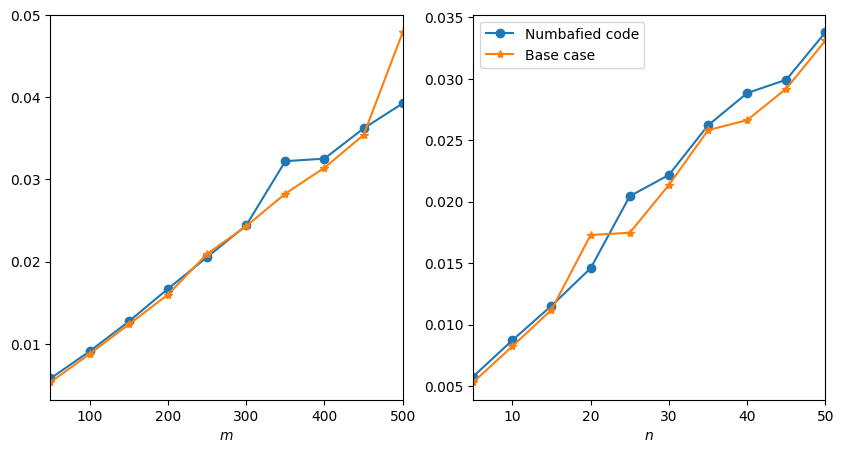

In [76]:
plt.subplots(1, 2, figsize=(10, 5))

t_numba_mean = [t_numba[(m, ns[0])].average for m in ms_to_plot]
t_numba_std = [t_numba[(m, ns[0])].stdev for m in ms_to_plot]
t_base_mean = [t_base[(m, ns[0])].average for m in ms_to_plot]
t_base_std = [t_base[(m, ns[0])].stdev for m in ms_to_plot]

plt.subplot(1, 2, 1)
plt.plot(ms_to_plot, t_numba_mean, marker='o')
plt.plot(ms_to_plot, t_base_mean, marker='*')
plt.xlim(ms_to_plot[0], ms_to_plot[-1])
plt.xlabel('$m$')

t_numba_mean = [t_numba[(ms[0], n)].average for n in ns_to_plot]
t_numba_std = [t_numba[(ms[0], n)].stdev for n in ns_to_plot]
t_base_mean = [t_base[(ms[0], n)].average for n in ns_to_plot]
t_base_std = [t_base[(ms[0], n)].stdev for n in ns_to_plot]

plt.subplot(1, 2, 2)
plt.plot(ns_to_plot, t_numba_mean, marker='o', label='Numbafied code')
plt.plot(ns_to_plot, t_base_mean, marker='*', label='Base case')
plt.xlim(ns_to_plot[0], ns_to_plot[-1])
plt.xlabel('$n$')
plt.legend()

plt.show()